# Import

In [5]:
import json
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your reranked CrossEncoder results

In [6]:
def get_latest_file(folder: Path, pattern: str) -> Path:
    files = list(folder.glob(pattern))
    if not files:
        raise FileNotFoundError(f"No files found matching {pattern} in {folder}")
    # Pick file with latest timestamp in filename
    return max(files, key=lambda f: f.stem.split("_")[-1])

In [7]:
eval_folder = Path("../data/eval/results")  # adjust if needed

# Load your baseline evaluations

In [8]:
dense_file = get_latest_file(eval_folder, "dense_eval_*.json")
with open(dense_file) as f:
    dense_eval = json.load(f)
print(f"Loaded {len(dense_eval)} dense queries from {dense_file.name}")

Loaded 15 dense queries from dense_eval_20260125T151933.json


In [9]:
reranked_file = eval_folder / "reranked_crossencoder.json"
with open(reranked_file) as f:
    reranked_eval = json.load(f)
print(f"Loaded {len(reranked_eval)} reranked queries from {reranked_file.name}")

Loaded 15 reranked queries from reranked_crossencoder.json


In [10]:
reranked_by_query = {
    item["query"]: [doc["id"] for doc in item["reranked_docs"]]
    for item in reranked_eval
}

# Define metrics functions

In [11]:
def recall_at_k(relevant_ids, retrieved_ids, k):
    return int(any(doc_id in retrieved_ids[:k] for doc_id in relevant_ids))

def precision_at_k(relevant_ids, retrieved_ids, k):
    if k == 0:
        return 0.0
    hits = sum(1 for doc_id in retrieved_ids[:k] if doc_id in relevant_ids)
    return hits / k

def mrr(relevant_ids, retrieved_ids):
    for i, doc_id in enumerate(retrieved_ids, start=1):
        if doc_id in relevant_ids:
            return 1.0 / i
    return 0.0


# Compute metrics for reranked results

In [12]:
RERANK_K = 10

reranked_metrics = []

for item in dense_eval:  # or hybrid_eval if you want hybrid baseline
    query = item["query"]
    relevant_ids = item.get("relevant_doc_ids", [])

    if query not in reranked_by_query:
        continue

    reranked_ids = reranked_by_query[query]

    reranked_metrics.append({
        "query": query,
        "method": "Dense + CrossEncoder",
        "recall_at_k": recall_at_k(relevant_ids, reranked_ids, RERANK_K),
        "mrr": mrr(relevant_ids, reranked_ids),
        "precision_at_k": precision_at_k(relevant_ids, reranked_ids, RERANK_K),
    })


# Create a DataFrame to compare

In [13]:
import pandas as pd

df_baseline = pd.DataFrame(dense_eval)  # or hybrid_eval
df_baseline["method"] = "Dense"  # or "Hybrid"

df_reranked = pd.DataFrame(reranked_metrics)

metrics = ["recall_at_k", "mrr", "precision_at_k"]

df_all = pd.concat(
    [df_baseline[["query", "method"] + metrics], df_reranked],
    ignore_index=True
)
df_all.head()


,query,method,recall_at_k,mrr,precision_at_k
0,differences between Gemini developer API featu...,Dense,0,0.0,0.0
1,how to integrate Gemini API for building AI ap...,Dense,0,0.0,0.0
2,what is Gemini model family and how do I use i...,Dense,0,0.0,0.0
3,how do Gemini embeddings work for semantic sea...,Dense,0,0.0,0.0
4,how to run Gemini Nano on Android devices for ...,Dense,0,0.0,0.0


# Compute average metrics per method

In [14]:
avg_metrics = df_all.groupby("method")[metrics].mean().reset_index()
print(avg_metrics)


                 method  recall_at_k       mrr  precision_at_k
0                 Dense     0.400000  0.305556        0.080000
1  Dense + CrossEncoder     0.733333  0.550000        0.073333


# Visualize improvements

### bar plots

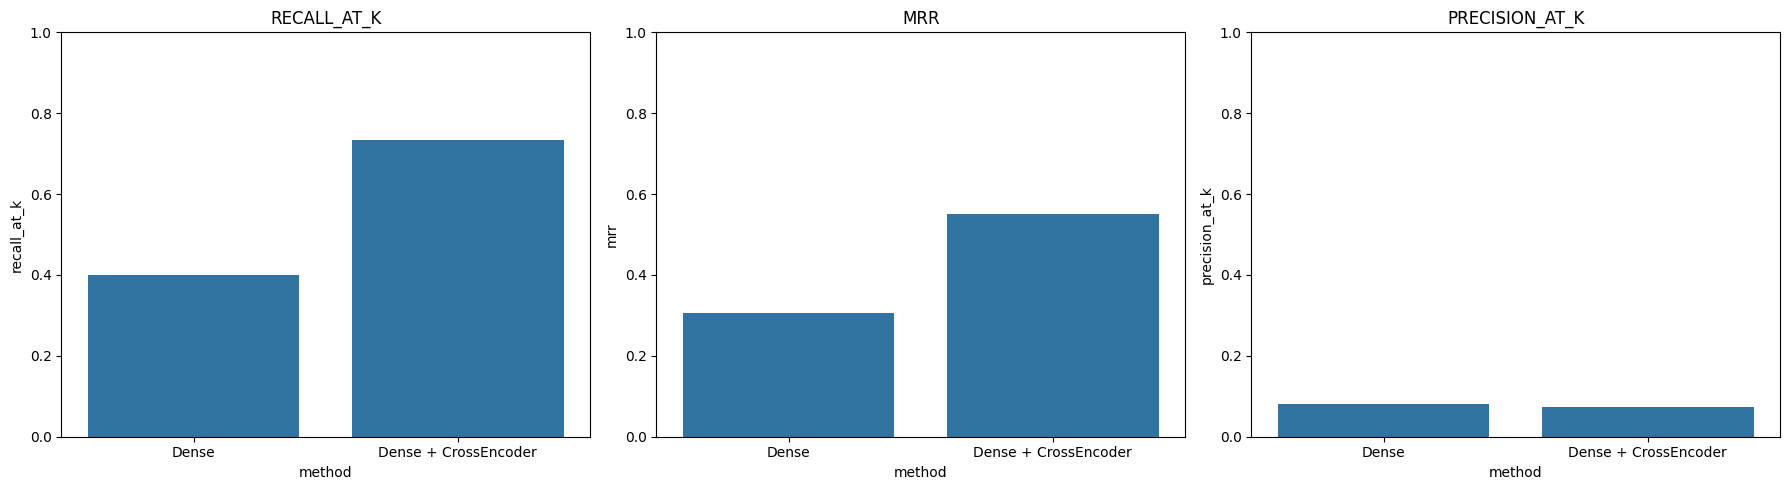

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18,5))

for i, metric in enumerate(metrics):
    sns.barplot(data=avg_metrics, x="method", y=metric, ax=axes[i])
    axes[i].set_title(metric.upper())
    axes[i].set_ylim(0, 1)

plt.tight_layout()
plt.show()


### MRR heatmap per query

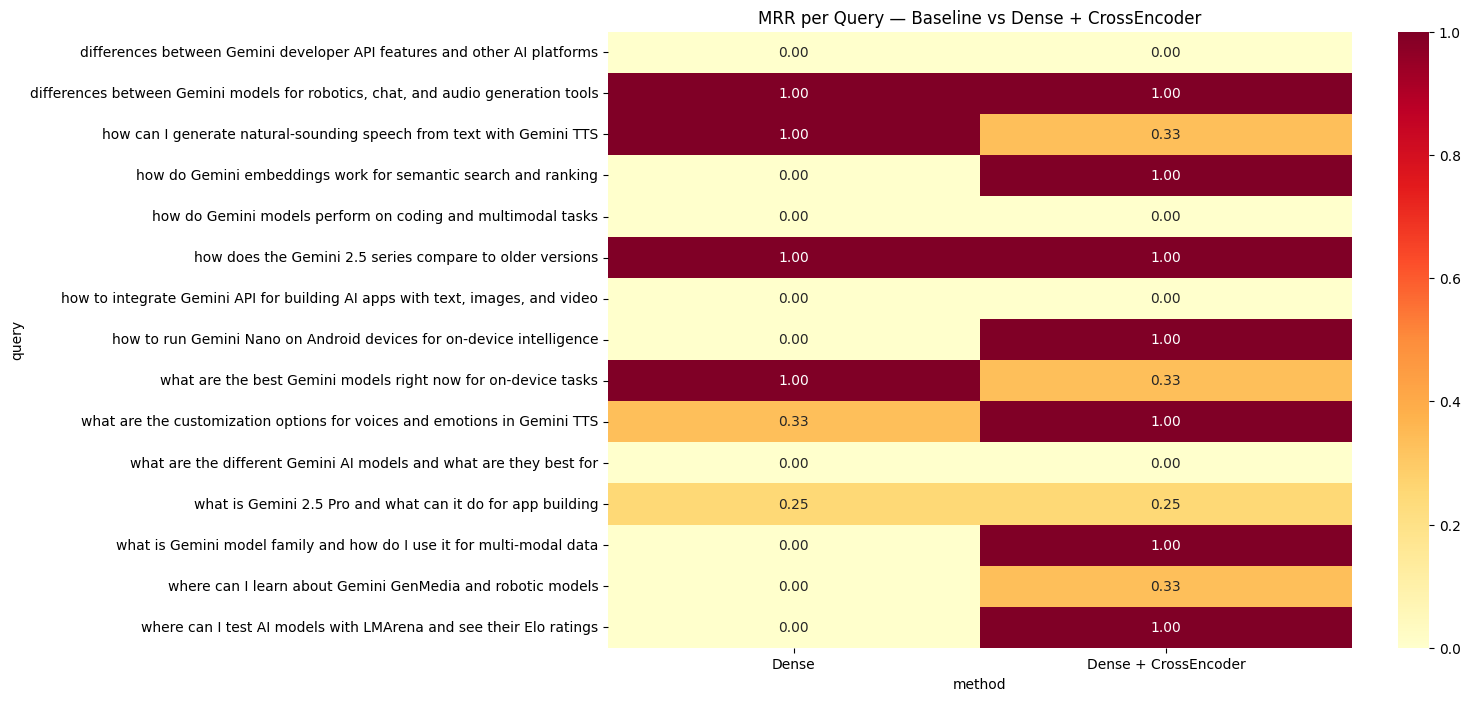

In [16]:
pivot = df_all.pivot(index="query", columns="method", values="mrr")

plt.figure(figsize=(12,8))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="YlOrRd")
plt.title("MRR per Query — Baseline vs Dense + CrossEncoder")
plt.show()


### ΔMRR distribution

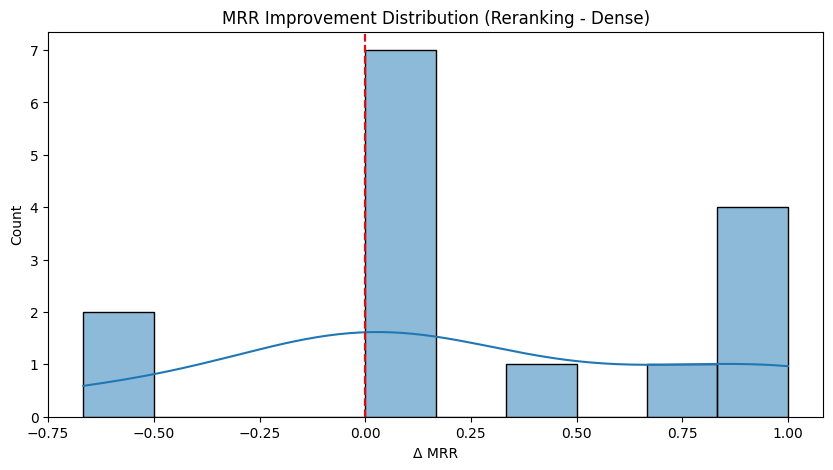

Queries improved: 6
Queries worsened: 2
Unchanged: 7


In [17]:
delta = pivot["Dense + CrossEncoder"] - pivot["Dense"]

plt.figure(figsize=(10,5))
sns.histplot(delta, bins=10, kde=True)
plt.axvline(0, color="red", linestyle="--")
plt.title("MRR Improvement Distribution (Reranking - Dense)")
plt.xlabel("Δ MRR")
plt.show()

print(f"Queries improved: {(delta > 0).sum()}")
print(f"Queries worsened: {(delta < 0).sum()}")
print(f"Unchanged: {(delta == 0).sum()}")
